In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [38]:
import random
from nltk import word_tokenize

In [4]:
def factorizer(arr):
    d={}
    c = 0
    for i in arr:
        if i not in d:
            d[i] = c
            c+=1
        else:
            pass
    return d, [d[i] for i in arr]

In [13]:
data = pd.read_csv('All-seasons.csv')
data['Line'] = [line.strip() for line in data['Line']]
factors_dict, data['CharFact'] = factorizer(data['Character'])
data.head()

,Season,Episode,Character,Line,CharFact
0,10,1,Stan,"You guys, you guys! Chef is going away.",0
1,10,1,Kyle,Going away? For how long?,1
2,10,1,Stan,Forever.,0
3,10,1,Chef,I'm sorry boys.,2
4,10,1,Stan,"Chef said he's been bored, so he joining a gro...",0


In [15]:
names = ['Cartman', 'Stan', 'Kyle', 'Butters', 'Randy', 'Mr. Garrison']

In [16]:
data = pd.concat([data[data['Character']==name][:1000] for name in names])

In [17]:
data['Character'].value_counts()[:10]

Mr. Garrison    1000
Cartman         1000
Randy           1000
Kyle            1000
Butters         1000
Stan            1000
Name: Character, dtype: int64

In [26]:
data['CharFact'] = data['Character'].map(lambda x: names.index(x))

Мы создали сбалансированный датасет с репликами 6 самых частотных персонажей.

In [23]:
from sklearn.metrics import classification_report

In [18]:
def baseline(data):
    return [random.randint(0, 5) for i in range(len(data))]

In [27]:
print(classification_report(data['CharFact'], baseline(data['CharFact'])))

             precision    recall  f1-score   support

          0       0.17      0.17      0.17      1000
          1       0.16      0.17      0.17      1000
          2       0.18      0.17      0.18      1000
          3       0.15      0.15      0.15      1000
          4       0.18      0.17      0.17      1000
          5       0.15      0.15      0.15      1000

avg / total       0.17      0.17      0.17      6000



Мы узнали, как хорошо работает baseline-классификатор. Теперь задача в том, чтобы сделать лучше, чем он.

In [39]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
vectrzr = TfidfVectorizer(tokenizer=tokenize)
matrix = vectrzr.fit_transform(data['Line'])

In [21]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(matrix, data['CharFact'], test_size=0.2)

Мы векторизовали документы по tf-idf, предварительно лемматизировав слова (потому что так f1-score на 0.01 лучше, чем без лемматизации).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [29]:
parameters = {'C': [1, 10, 100, 1000], 'fit_intercept': [False, True], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}

In [42]:
logit = LogisticRegression()
clf_logit = GridSearchCV(logit, parameters)
clf_logit.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [False, True], 'solver': ['newton-cg', 'lbfgs'], 'C': [1, 10, 100, 1000], 'multi_class': ['ovr', 'multinomial']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [47]:
print(classification_report(clf_logit.predict(X_train), y_train))

             precision    recall  f1-score   support

          0       0.86      0.82      0.84       831
          1       0.75      0.74      0.75       793
          2       0.78      0.79      0.78       801
          3       0.85      0.85      0.85       810
          4       0.85      0.86      0.86       782
          5       0.87      0.91      0.89       783

avg / total       0.83      0.83      0.83      4800



In [35]:
clf_logit.best_params_

{'C': 1, 'fit_intercept': True, 'multi_class': 'ovr', 'solver': 'newton-cg'}

In [36]:
logit = LogisticRegression(C=1, fit_intercept=True, multi_class='ovr', solver='newton-cg')
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

Мы обучили логит-регрессию, она неплохо работает. На тренировочных данных, по крайней мере.

In [45]:
from sklearn.ensemble import RandomForestClassifier
forest_params = {'max_features':[.25, .3, .5, 'sqrt', 'log2', None], 'max_depth':[10, 100, 1000, 10000, None], 'bootstrap':[True, False]}

In [60]:
clf_forest = GridSearchCV(RandomForestClassifier(), forest_params)
clf_forest.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [0.25, 0.3, 0.5, 'sqrt', 'log2', None], 'max_depth': [10, 100, 1000, 10000, None], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [48]:
clf_forest.best_params_

{'bootstrap': True, 'max_depth': None, 'max_features': 0.5}

In [49]:
print(classification_report(clf_forest.predict(X_train), y_train))

             precision    recall  f1-score   support

          0       0.97      0.96      0.96       798
          1       0.97      0.89      0.93       856
          2       0.92      0.98      0.95       758
          3       0.96      0.95      0.96       819
          4       0.94      0.98      0.96       767
          5       0.97      0.99      0.98       802

avg / total       0.96      0.95      0.95      4800



Случайный лес на тренировочных данных тоже супер.

In [54]:
from sklearn.naive_bayes import MultinomialNB
bayes_params = {'alpha':[.1, .25, .3, .5, .75, .9, 1.0], 'fit_prior':[True, False]}

In [55]:
clf_bayes = GridSearchCV(MultinomialNB(), bayes_params)
clf_bayes.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'fit_prior': [True, False], 'alpha': [0.1, 0.25, 0.3, 0.5, 0.75, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [56]:
print(classification_report(clf_bayes.predict(X_train), y_train))

             precision    recall  f1-score   support

          0       0.77      0.78      0.77       784
          1       0.70      0.63      0.66       872
          2       0.73      0.68      0.70       858
          3       0.77      0.84      0.80       744
          4       0.77      0.83      0.80       733
          5       0.81      0.82      0.81       809

avg / total       0.76      0.76      0.76      4800



Как видно, лучшей моделью (судя по тренировочным данным) у нас оказался лес.

***Финальная битва на тестовых данных***

In [57]:
print(classification_report(clf_logit.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.44      0.48      0.46       192
          1       0.38      0.40      0.39       203
          2       0.44      0.38      0.41       226
          3       0.41      0.47      0.44       172
          4       0.51      0.47      0.49       220
          5       0.59      0.57      0.58       187

avg / total       0.46      0.46      0.46      1200



In [58]:
print(classification_report(clf_forest.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.38      0.33      0.35       242
          1       0.38      0.34      0.35       244
          2       0.28      0.31      0.29       171
          3       0.36      0.32      0.34       217
          4       0.34      0.40      0.37       176
          5       0.36      0.43      0.39       150

avg / total       0.35      0.35      0.35      1200



In [59]:
print(classification_report(clf_bayes.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.48      0.51      0.50       195
          1       0.41      0.38      0.39       239
          2       0.44      0.37      0.40       231
          3       0.37      0.51      0.43       142
          4       0.53      0.54      0.53       203
          5       0.58      0.56      0.57       190

avg / total       0.47      0.47      0.47      1200



На тестовой выборке наивный байес оказался лучше всех.

In [61]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [63]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

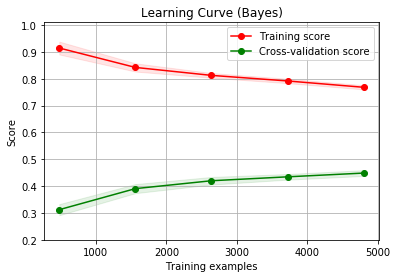

In [64]:
title = "Learning Curve (Bayes)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = clf_bayes
plot_learning_curve(estimator, title, matrix, data['CharFact'], ylim=(0.2, 1.01), cv=cv, n_jobs=1)